Open this notebook in Google Colab : [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Riminder/hrflow-cookbook/blob/main/examples/%5BHybrid%20Scoring%5D%20unified_scoring_&_grading_pipeline.ipynb)

##### © 2025 HrFlow.ai — AI Research Department  
Licensed under the Apache License, Version 2.0.

In [ ]:
# Copyright 2025 HrFlow's AI Research Department. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 🎯 Unified HrFlow.ai Scoring & Grading Pipeline

Welcome! This notebook demonstrates how to build an end-to-end matching pipeline using HrFlow.ai’s APIs. You'll learn how to:
- Parse a job offer using the Parsing API,
- Score database profiles using the Scoring API,
- Grade candidates using the Grading API,
- Retrieve and visualize the best-matching profiles.

Let’s get started!

<details>
  <summary><strong>📚 Table of Contents</strong></summary>

- [🧠 Goal](#goal)
- [⚙️ Setup](#setup)
- [🧩 Configuration](#configuration)
- [🛠️ Define Pipeline Functions](#define-pipeline-functions)
- [🚀 Run the Pipelines](#run-the-pipelines)
- [✅ Conclusion](#conclusion)

</details>

<a name="goal"></a>
## 🧠 **Goal**

This notebook shows how to retrieve the **top N best-matching profiles** for a specific job offer using **HrFlow.ai’s Parsing, Scoring, and Grading APIs**.

It walks through the process of:
1. Extracting job information from a job description text,
2. Scoring each candidate in your database against the job offer,
3. Grading the top-scoring candidates,
4. Returning a ranked list of best matches.

Perfect for HR teams looking to streamline candidate-job matching using AI.

> ✅ This method works for **any number of profiles**, from one or multiple sources, and is fully configurable.

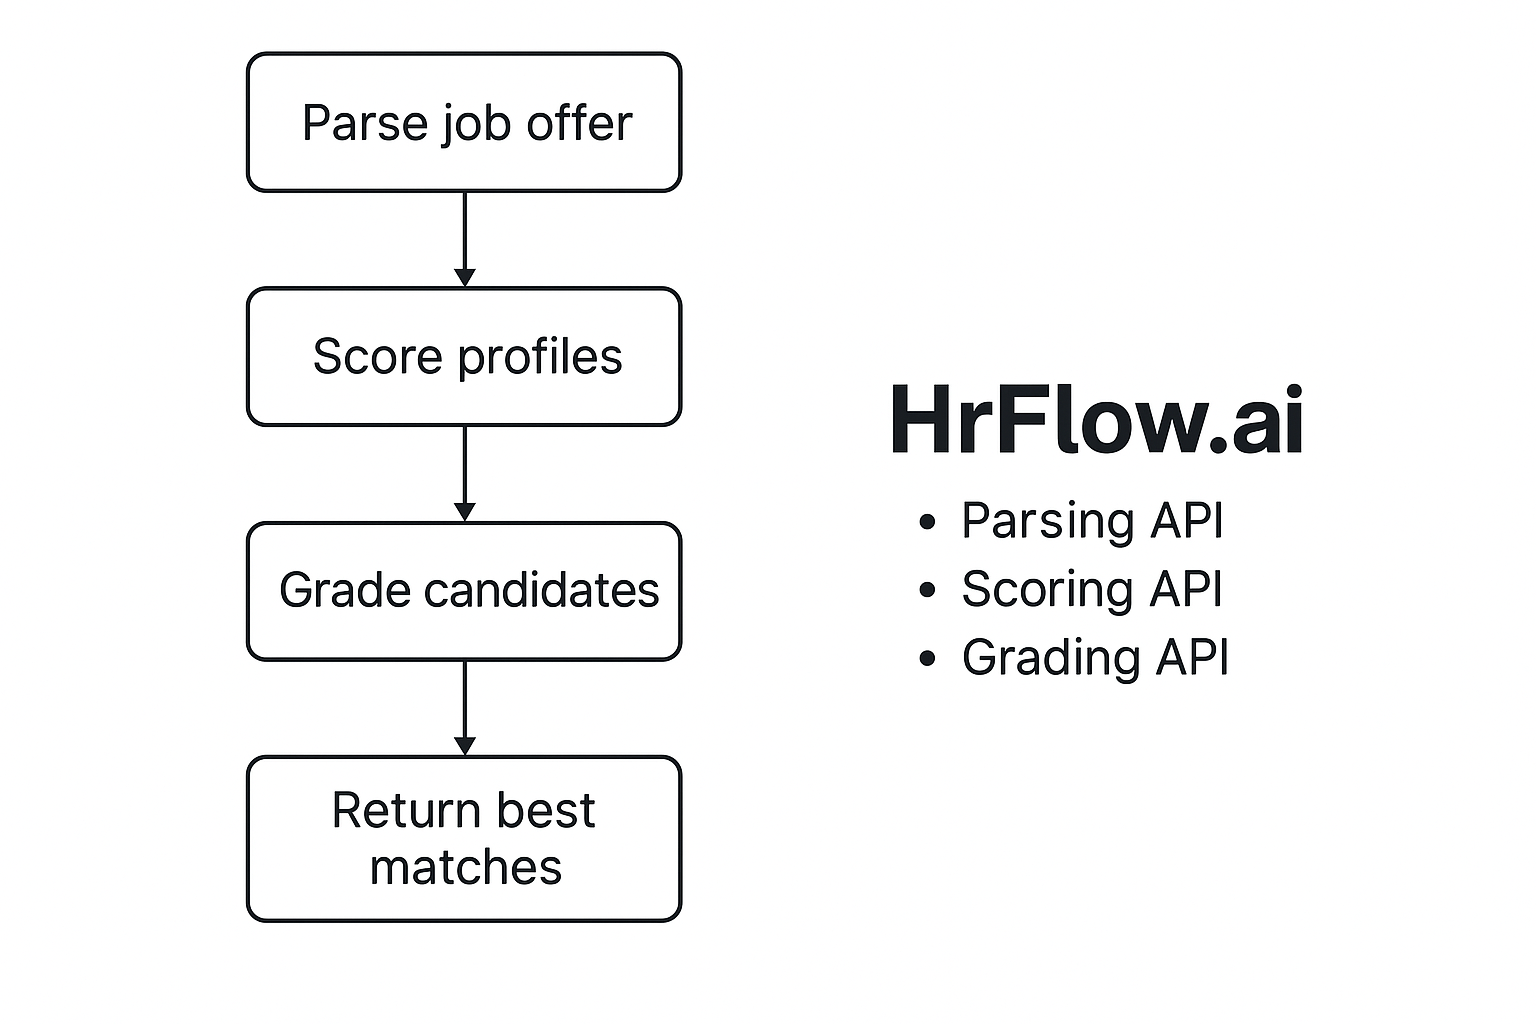

<a name="setup"></a>
## ⚙️ **Setup**
Let’s install and import the necessary Python packages to run the pipeline.

In [3]:
!pip install -q -U hrflow

In [4]:
from getpass import getpass
from hrflow import Hrflow
import requests
import os
from tqdm import tqdm
from typing import List, Dict, Any

### 🔐 Authenticate with your HrFlow.ai API credentials

You’ll be prompted to enter:

- `API_SECRET`: Your HrFlow Read/Write API Secret Key →  
  Get it here: `https://{subdomain}.hrflow.ai/settings/api/keys`
  
- `API_USER`: Your HrFlow user email address


In [5]:
API_SECRET = getpass("YOUR_API_SECRET")
API_USER = getpass("USER@EMAIL.DOMAIN")

client = Hrflow(api_secret=API_SECRET, api_user=API_USER)

YOUR_API_SECRET··········
USER@EMAIL.DOMAIN··········


<a name="configuration"></a>
## 🧩 **Configuration**

Now we configure the credentials and parameters needed for calling HrFlow.ai’s APIs.

📥 **Fill in the following required values:**

- `SOURCE_KEYS`: List of source keys (from **Connections > My Sources**)  
- `BOARD_KEY`: Board in which the offer will get parsed (from **Connections > My Boards**)  
- `SCORING_ALGORITHM_KEY`: From **AI Studio > My Scoring Algorithms**  
- `GRADING_ALGORITHM_KEY`: Choose between:
  - `grader-hrflow-profiles`
  - `grader-hrflow-profiles-recruiting`
- `NUMBER_OF_PROFILES_TO_GRADE`: Number of profiles to grade, if 0 no grading will be done
- `NUMBER_OF_PROFILES_TO_RETURN`: Final number of top profiles to return

In [1]:
SOURCE_KEYS = ["source_key"]  # List of source keys
BOARD_KEY = "board_key"
SCORING_ALGORITHM_KEY = "scoring_algorithm_key"
GRADING_ALGORITHM_KEY = "grader-hrflow-profiles"  # or 'grader-hrflow-profiles-recruiting'

NUMBER_OF_PROFILES_TO_RETURN = 100
NUMBER_OF_PROFILES_TO_GRADE = 50

<a name="define-pipeline-functions"></a>
## 🛠️ **Define Pipeline Functions**

This section contains modular functions for:
- Parsing job descriptions,
- Scoring profiles,
- Grading candidates.

Each function encapsulates a clear API call or transformation for easy reuse.

In [ ]:
def parse_job_offer_text(job_offer_text: str) -> Dict[str, Any]:
    """
    Calls HrFlow Parsing API to parse the job offer text and returns the job object.
    """
    parsing_url = "https://api.hrflow.ai/v1/text/parsing"
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "X-API-KEY": API_SECRET,
        "X-USER-EMAIL": API_USER
    }
    payload = {
        "texts": [job_offer_text],
        "parsing_model": "atlas",
        "output_object": "job"
    }

    response = requests.post(parsing_url, json=payload, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Error while parsing job offer text: {response.json()['message']}")

    job_parsing = response.json()["data"][0]["job"]

    # Remove unnecessary fields
    job_parsing.pop("key")
    job_parsing.pop("board_key")
    job_parsing.pop("board")

    return job_parsing


def store_job(job: Dict[str, Any], board_key: str) -> str:
    """
    Stores the job in HrFlow and returns the job key.
    """
    response = client.job.storing.add_json(board_key=board_key, job_json=job)
    if response["code"] // 100 == 2:
        raise Exception(f"Error while storing job: {response['message']}")
    return response["data"]["key"]


In [ ]:

def fetch_scored_profiles(
    source_keys: List[str],
    board_key: str,
    job_key: str,
    scoring_agent_key: str,
    max_profiles: int,
    profiles_per_page: int = 30
) -> List[Dict[str, Any]]:
    """
    Fetches profiles using HrFlow Scoring API and returns a list of profiles with their scoring scores.
    """
    page = 1
    scored_profiles = []

    while True:
        response = hrflow_client.profile.scoring.list(
            source_keys=source_keys,
            board_key=board_key,
            job_key=job_key,
            agent_key=scoring_agent_key,
            limit=profiles_per_page,
            page=page,
            sort_by="scoring",
            order_by="desc"
        )

        if response["code"] != 200:
            raise Exception(f"Error while fetching scoring results: {response['message']}")

        scores = [score_pair[1] for score_pair in response["data"]["predictions"]]
        profiles = response["data"]["profiles"]

        scored_profiles.extend([
            {"profile": profile, "score": score}
            for profile, score in zip(profiles, scores)
        ])

        if page >= response["meta"]["maxPage"] or len(scored_profiles) >= max_profiles:
            break

        page += 1

    return scored_profiles[:max_profiles]


def fetch_grading_score(
    api_secret: str,
    api_user: str,
    profile: Dict[str, Any],
    board_key: str,
    job_key: str,
    grading_agent_key: str
) -> float:
    """
    Calls HrFlow Grading API for a single profile and returns the grading score.
    """
    grading_url = "https://api.hrflow.ai/v1/profile/grading"
    headers = {
        "accept": "application/json",
        "X-API-KEY": api_secret,
        "X-USER-EMAIL": api_user
    }
    params = {
        "source_key": profile["source_key"],
        "profile_key": profile["key"],
        "board_key": board_key,
        "job_key": job_key,
        "algorithm_key": grading_agent_key
    }

    response = requests.get(grading_url, headers=headers, params=params)

    if response.status_code != 200:
        raise Exception(f"Error while grading profile {profile['key']}: {response.json()['message']}")

    return response.json()["data"]["data"]["score"]


def grade_top_profiles(
    api_secret: str,
    api_user: str,
    scored_profiles: List[Dict[str, Any]],
    board_key: str,
    job_key: str,
    grading_agent_key: str,
    top_n: int
) -> List[Dict[str, Any]]:
    """
    Grades the top N profiles from the scored list using the Grading API.
    """
    graded_profiles = []

    for profile_entry in tqdm(scored_profiles[:top_n], desc="Grading profiles"):
        profile = profile_entry["profile"]
        grade = fetch_grading_score(api_secret, api_user, profile, board_key, job_key, grading_agent_key)
        graded_profiles.append({"profile": profile, "score": grade})

    graded_profiles.sort(key=lambda x: x["score"], reverse=True)
    return graded_profiles


def merge_with_harmonized_scores(
    graded_profiles: List[Dict[str, Any]],
    all_scored_profiles: List[Dict[str, Any]]
) -> List[Dict[str, Any]]:
    """
    Scales ungraded profile scores so that they remain below the lowest graded profile score.
    Returns the combined and harmonized profile list.
    """
    cutoff_score = graded_profiles[-1]["score"]
    ungraded_profiles = all_scored_profiles[len(graded_profiles):]

    harmonized_ungraded = [
        {
            "profile": p["profile"],
            "score": p["score"] * cutoff_score
        }
        for p in ungraded_profiles
    ]

    return graded_profiles + harmonized_ungraded

def get_resumes_from_scored_profiles(
    scored_profiles: List[Dict[str, Any]]
) -> List[str]:
    """
    Extracts and returns the public URLs of resumes from the scored profiles.
    """
    profiles_list = [entry["profile"] for entry in scored_profiles]

    resume_urls = []

    for profile in profiles_list:
        resume_urls.append(profile["attachments"][0]["public_url"])
    return resume_urls

<a name="run-the-pipelines"></a>
## 🚀 **Run the Pipeline**

We now:
1. Parse the job description,
2. Score the entire profile database,
3. Grade the top results,
4. Return a sorted list of top matches.

Let’s go!

📝 **Define the Job Offer**

Let’s specify the job offer we want to match candidates against. The content will be parsed using the HrFlow.ai Parsing API.

Feel free to replace it with your own job description.


In [ ]:
job_offer_text = """
job offer text here
"""

In [ ]:
job_parsing = parse_job_offer_text(job_offer_text)
job_key = store_job(job_parsing, BOARD_KEY)

scored_profiles = fetch_scored_profiles(
    source_keys=SOURCE_KEYS,
    board_key=BOARD_KEY,
    job_key=job_key,
    scoring_agent_key=SCORING_ALGORITHM_KEY,
    max_profiles=NUMBER_OF_PROFILES_TO_RETURN
)

graded_profiles = grade_top_profiles(
    api_secret=API_SECRET,
    api_user=API_USER,
    scored_profiles=scored_profiles,
    board_key=BOARD_KEY,
    job_key=JOB_KEY,
    grading_agent_key=GRADING_ALGORITHM_KEY,
    top_n=NUMBER_OF_PROFILES_TO_GRADE
)

final_profiles = merge_with_harmonized_scores(
    graded_profiles=graded_profiles,
    all_scored_profiles=scored_profiles
)
final_profiles_resumes = get_resumes_from_scored_profiles(final_profiles)

<a name="conclusion"></a>
## ✅ Conclusion

With just a few steps, we’ve built a powerful pipeline that automates the matching process between a job offer and a candidate database using HrFlow.ai.

Feel free to expand this notebook by:
- Adding visualization for score/grading distribution,
- Writing results to a CSV,
- Running it on a schedule using Google Colab + webhooks.

Stay smart with your hiring!
